# Sepsis-3 evaluation in the MIMIC-III database

This notebook goes over the evaluation of the new Sepsis-3 guidelines in the MIMIC database. The goals of this analysis include:

1. Evaluating the Sepsis-3 guidelines in MIMIC using the same methodology as in the research paper
2. Evaluating the Sepsis-3 guidelines against ANGUS criteria
3. Assessing if there are interesting subgroup(s) which are missed by the criteria

In [1]:
from __future__ import print_function

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import OrderedDict

from sepsis_utils import sepsis_utils as su
from sepsis_utils import roc_utils as ru

# used to calculate AUROC
from sklearn import metrics

# default colours for prettier plots
col = [[0.9047, 0.1918, 0.1988],
    [0.2941, 0.5447, 0.7494],
    [0.3718, 0.7176, 0.3612],
    [1.0000, 0.5482, 0.1000],
    [0.4550, 0.4946, 0.4722],
    [0.6859, 0.4035, 0.2412],
    [0.9718, 0.5553, 0.7741],
    [0.5313, 0.3359, 0.6523]];
marker = ['v','o','d','^','s','o','+']
ls = ['-','-','-','-','-','s','--','--']

%matplotlib inline

In [2]:
# load data
df = pd.read_csv('sepsis3-df.csv',sep=',')
df_mdl = pd.read_csv('sepsis3-design-matrix.csv',sep=',')

# define outcome
target_header = "angus"
y = df[target_header].values == 1

# define the covariates to be added in the MFP model (used for table of AUROCs)
preds_header = ['sirs','qsofa','sofa','mlods']

# Study question

How well do the guidelines detect sepsis (Angus criteria) in the antibiotics/culture subset?

## Angus criteria evaluation

In [3]:
yhat = (df.sofa.values>=2)
print('\n SEPSIS-3 guidelines for Angus criteria sepsis \n')
print('Accuracy = {}'.format(metrics.accuracy_score(y, yhat)))
su.print_cm(y, yhat, header1='ang',header2='sofa') # print confusion matrix


 SEPSIS-3 guidelines for Angus criteria sepsis 

Accuracy = 0.503222996516

Confusion matrix
      	ang=0 	ang=1 
sofa=0	  4296	   841	NPV=83.63
sofa=1	 10565	  7258	PPV=40.72
   	28.91	89.62	Acc=50.32
   	Spec	Sens


Predictions using various levels of confounder adjustment are calculated in the subfunctions `calc_predictions`:

* `model=None` - the severity scores on their own
* `model='baseline'` - the severity scores in a vanilla regression
* `model='mfp'` -the severity scores in a fractional polynomial regression (calls an R script)

For Angus criteria we do not adjust for other factors when presenting the AUROCs.

In [4]:
preds = su.calc_predictions(df, preds_header, target_header, model=None)

In [5]:
# reproduce the AUC table
su.print_auc_table(preds, y, preds_header)
su.print_auc_table_to_file(preds, y, preds_header=preds_header,
                           filename='auc-table.csv')

     	sirs                	qsofa               	sofa                	mlods               	
sirs 	0.619 [0.612, 0.626]	0.538 [0.529, 0.549]	0.267 [0.258, 0.277]	0.310 [0.299, 0.320]	
qsofa	0.117               	0.626 [0.619, 0.632]	0.310 [0.304, 0.316]	0.393 [0.386, 0.399]	
sofa 	< 0.001               	< 0.001               	0.711 [0.704, 0.718]	0.874 [0.870, 0.877]	
mlods	< 0.001               	< 0.001               	0.512               	0.709 [0.703, 0.716]	


## Operating point statistics

This section evaluates the standard operating point statistics:

* sensitivity (% of true positives which are correctly classified)
* specificity (% of true negatives which are correctly classified)
* positive predictive value (given a positive prediction is made, what % are correct)
* negative predictive value (given a negative prediction is made, what % are correct)
* F1 score (harmonic mean of sensitivity and PPV)

In addition, we evaluate the number of false positives per 100 cases, or NFP/100. We feel this gives helpful perspective in interpretting the positive predictive value of the prediction and its relationship to the prevalance of the outcome. In this context, the measure can be summarized as: given 100 patients with suspected infection, how many will each algorithm inappropriately give a positive prediction?

In [20]:
# sepsis3 defined as qSOFA >= 2 and SOFA >= 2
yhat_dict = OrderedDict([['SOFA', df.sofa.values >= 2],
                        ['mLODS', df.mlods.values >= 2],
                        ['mLODS 2', df.mlods.values >= 1],
                        ['SIRS', df.sirs.values >= 2],
                        ['qSOFA', df.qsofa.values >= 2]])

stats_all = su.get_op_stats(yhat_dict, y)

su.print_op_stats(stats_all)

Metric

     	SOFA    	mLODS   	mLODS 2 	SIRS    	qSOFA   
TN   	 4296		 8004		 3946		 4753		 9029
FP   	10565		 6857		10915		10108		 5832
FN   	  841		 1897		  565		 1473		 3190
TP   	 7258		 6202		 7534		 6626		 4909
Sens 	90 [89, 90]	77 [76, 77]	93 [92, 94]	82 [81, 83]	61 [60, 62]
Spec 	29 [28, 30]	54 [53, 55]	27 [26, 27]	32 [31, 33]	61 [60, 62]
PPV  	41 [40, 41]	47 [47, 48]	41 [40, 42]	40 [39, 40]	46 [45, 47]
NPV  	84 [83, 85]	81 [80, 82]	87 [86, 88]	76 [75, 77]	74 [73, 75]
F1   	 56.00   	 58.63   	 56.76   	 53.36   	 52.11   
NTP  	 31.61   	 27.01   	 32.81   	 28.86   	 21.38   
NFP  	 46.01   	 29.86   	 47.54   	 44.02   	 25.40   


## Relation between SOFA/Lactate and hospital mortality

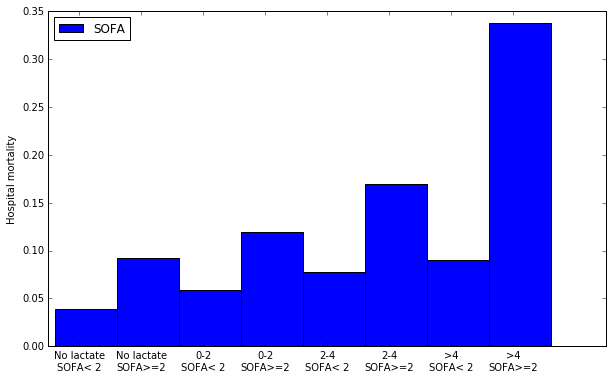

In [105]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )

idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA,
                                          strAdd=strAdd, targetStr='hospital_expire_flag')

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=1.0)
plt.xticks(np.linspace(0.5,7.5,8), lbl_sofa)
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality")
plt.show()

## Relation between SOFA/Lactate and angus

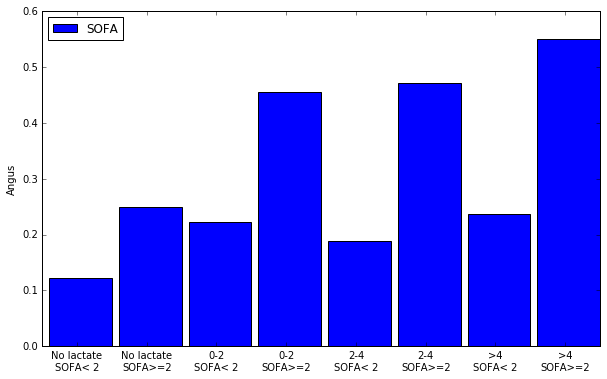

In [113]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )

idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA,
                                          strAdd=strAdd, targetStr='angus')

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=0.9)
plt.xticks(np.linspace(0.5,7.5,8), lbl_sofa)
plt.legend(loc='upper left')
plt.ylabel("Angus")
plt.show()

## Model using lactate

In [118]:
# regression using SOFA + LACTATE
from statsmodels.formula.api import logit

df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_measured'] = ~df_tmp['lactate_max'].isnull()
df_tmp['lactate_0_2'] = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp['lactate_2_4'] = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp['lactate_4'] = (df_tmp['lactate_max']>4)

formula = "angus ~ lactate_0_2 + lactate_2_4 + lactate_4"
sofa_model = logit(formula=formula + " + sofa",data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:30s}\t{:2.2f}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i])))


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22955
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Feb 2017   Pseudo R-squ.:                  0.1153
Time:                        12:24:29   Log-Likelihood:                -13186.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.0506      0.033    -62.027      0.000      -2.115      -1.986
lactate_0_2[T.True]     0.7570      0.038     19.819      0.000       0.682       0.832
lactate_2

In [136]:
# regression using SOFA + LACTATE
df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_measured'] = ~df_tmp['lactate_max'].isnull()
df_tmp['lactate_0_2'] = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp['lactate_2_4'] = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp['lactate_4'] = (df_tmp['lactate_max']>4)

# impute 0 for missing lactates
df_tmp.loc[df_tmp['lactate_measured']==0, 'lactate_max'] = 0

formula = "angus ~ lactate_measured + sofa"
sofa_model = logit(formula=formula,data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:30s}\t{:2.2f}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i])))


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22955
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Feb 2017   Pseudo R-squ.:                  0.1167
Time:                        13:06:47   Log-Likelihood:                -13165.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.1295      0.036    -58.815      0.000      -2.200      -2.059
lactate_measured[T.True]     0.7528      0.041     18.178      0.000       0.672  

In [131]:
# regression using SOFA + LACTATE
df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_measured'] = ~df_tmp['lactate_max'].isnull()
df_tmp['lactate_0_2'] = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp['lactate_2_4'] = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp['lactate_4'] = (df_tmp['lactate_max']>4)
df_tmp['sofa_2'] = (df_tmp['sofa']>=2)

# impute 0 for missing lactates
#df_tmp.loc[df_tmp['lactate_measured']==0, 'lactate_max'] = 0

formula = "angus ~ lactate_measured + lactate_2_4 + lactate_4"
sofa_model = logit(formula=formula + " + sofa_2",data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:30s}\t{:2.2f}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i])))
        
        
# confusing matrix of predictions
print('\nConfusing matrix of pred (yhat) and target (y)\n')
su.print_cm(df_tmp.angus.values, sofa_pred>=0.25, header1='y',header2='yhat') # print confusion matrix


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22955
Method:                           MLE   Df Model:                            4
Date:                Mon, 20 Feb 2017   Pseudo R-squ.:                 0.07267
Time:                        12:31:36   Log-Likelihood:                -13821.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -2.1324      0.043    -49.343      0.000      -2.217      -2.048
lactate_measured[T.True]     0.8833      0.037     23.631      0.000       0.810  

In [134]:
# regression using SOFA + LACTATE
df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_categorical'] = (~df_tmp['lactate_max'].isnull()).astype(int)
# missing lactates are given a 0

# now assign categores:
#  1 - lactate ~ (0, 2]
#  2 - lactate ~ (2, 4]
#  3 - lactate ~ (4, inf)
idx = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp.loc[idx, 'lactate_categorical'] = 1

idx = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp.loc[idx, 'lactate_categorical'] = 2

idx = (df_tmp['lactate_max']>4)
df_tmp.loc[idx, 'lactate_categorical'] = 3
df_tmp['sofa_2'] = (df_tmp['sofa']>=2)

# impute 0 for missing lactates
#df_tmp.loc[df_tmp['lactate_measured']==0, 'lactate_max'] = 0

formula = "angus ~ C(lactate_categorical):sofa_2"
sofa_model = logit(formula=formula,data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:30s}\t{:2.2f}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i])))
        
        
# confusing matrix of predictions
print('\nConfusing matrix of pred (yhat) and target (y)\n')
su.print_cm(df_tmp.angus.values, sofa_pred>=0.25, header1='y',header2='yhat') # print confusion matrix


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22952
Method:                           MLE   Df Model:                            7
Date:                Mon, 20 Feb 2017   Pseudo R-squ.:                 0.07340
Time:                        13:04:49   Log-Likelihood:                -13810.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                    -1.9714      0.058    -33.956      0.000      -2.085      -1.858
sofa_2[T.True]                 

# Appendix

## Relation of SOFA/Lactate or LODS/Lactate and hospital mortality

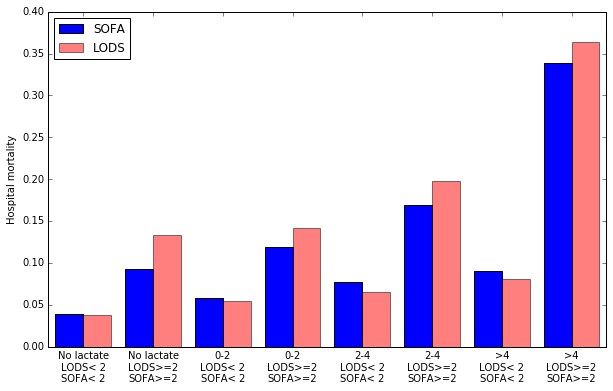

In [32]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )


idxA = (df['mlods']>=2).values
strAdd = ['LODS< 2','LODS>=2']
x_lods, lbl_lods = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd)


idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd)

lbl = [lbl_lods[i] 
       + '\n' + lbl_sofa[i].split('\n')[1]
       for i in range(len(lbl_lods))]

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.1,x_sofa,facecolor='b', label='SOFA',width=0.4)
plt.bar(xi+0.5,x_lods,facecolor='r',alpha=0.5,label='LODS',width=0.4)
plt.xticks(np.linspace(0.5,7.5,8), lbl)
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality")
plt.show()

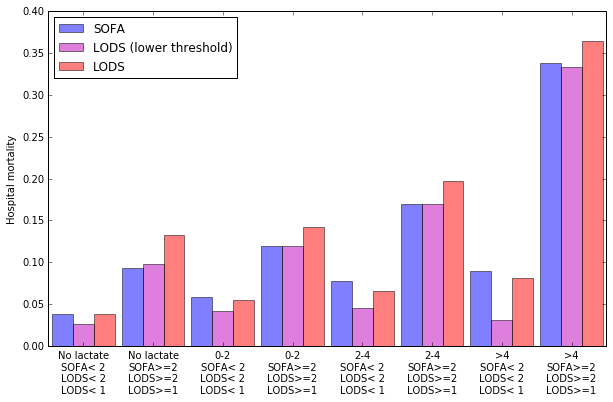

In [29]:
groups = OrderedDict( [['No lactate', df['lactate_max'].isnull()],
         ['0-2', (df['lactate_max']>=0) & (df['lactate_max']<=2)],
         ['2-4', (df['lactate_max']> 2) & (df['lactate_max']<=4)],
         ['>4', (df['lactate_max']> 4) & (df['lactate_max']<=200)]] )

idxA = (df['mlods']>=2).values
strAdd = ['LODS< 2','LODS>=2']
x_lods, lbl_lods = create_grouped_hist(df, groups, idxA, strAdd=strAdd)

idxA = (df['sofa']>=2).values
strAdd = ['SOFA< 2','SOFA>=2']
x_sofa, lbl_sofa = create_grouped_hist(df, groups, idxA, strAdd=strAdd)


idxA = (df['mlods']>=1).values
strAdd = ['LODS< 1','LODS>=1']
x_lods_1, lbl_lods_1 = su.create_grouped_hist(df, groups, idxA, strAdd=strAdd)

lbl = [lbl_sofa[i] 
       + '\n' + lbl_lods[i].split('\n')[1]
       + '\n' + lbl_lods_1[i].split('\n')[1]
       for i in range(len(lbl_lods))]

plt.figure(figsize=[10,6])
xi = np.linspace(0,7,8)
plt.bar(xi+0.05,x_sofa,facecolor='b',alpha=0.5,label='SOFA',width=0.3)
plt.bar(xi+0.35,x_lods_1,facecolor='m',alpha=0.5, label='LODS (lower threshold)',width=0.3)
plt.bar(xi+0.65,x_lods,facecolor='r',alpha=0.5,label='LODS',width=0.3)
plt.xticks(np.linspace(0.5,7.5,8), lbl)
plt.legend(loc='upper left')
plt.ylabel("Hospital mortality")
plt.show()

In [103]:
# regression using SOFA + LACTATE
from statsmodels.formula.api import logit

df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_miss'] = df_tmp['lactate_max'].isnull()
df_tmp['lactate_0_2'] = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp['lactate_2_4'] = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp['lactate_4'] = (df_tmp['lactate_max']>4)

formula = "angus ~ lactate_0_2 + lactate_2_4 + lactate_4"
sofa_model = logit(formula=formula + " + sofa",data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

lods_model = logit(formula=formula + " + lods",data=df_tmp).fit(disp=0)
lods_pred = lods_model.predict()
print("\n\tLODS")
print(lods_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )
auc, auc_ci = ru.calc_auc(lods_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for LODS: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:20s}\t{:2.2f}\t{:2.2f}\t{:20s}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i]),
                                                np.exp(lods_model.params[i]),
                                               lods_model.params.index[i]))


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22955
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Feb 2017   Pseudo R-squ.:                  0.1153
Time:                        16:02:07   Log-Likelihood:                -13186.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.0506      0.033    -62.027      0.000      -2.115      -1.986
lactate_0_2[T.True]     0.7570      0.038     19.819      0.000       0.682       0.832
lactate_2

In [102]:
# regression using SOFA + LACTATE
from statsmodels.formula.api import logit

df_tmp = df[['angus','lactate_max','sofa','lods']].copy()
df_tmp['lactate_miss'] = df_tmp['lactate_max'].isnull()
df_tmp['lactate_0_2'] = (df_tmp['lactate_max']>0) & (df_tmp['lactate_max']<=2)
df_tmp['lactate_2_4'] = (df_tmp['lactate_max']>2) & (df_tmp['lactate_max']<=4)
df_tmp['lactate_4'] = (df_tmp['lactate_max']>4)
df_tmp['sofa_2'] = (df_tmp['sofa']>=2)
df_tmp['lods_2'] = (df_tmp['lods']>=2)

formula = "angus ~ lactate_0_2 + lactate_2_4 + lactate_4"
sofa_model = logit(formula=formula + " + sofa_2",data=df_tmp).fit(disp=0)
sofa_pred = sofa_model.predict()
print("\n\tSOFA")
print(sofa_model.summary())

lods_model = logit(formula=formula + " + lods_2",data=df_tmp).fit(disp=0)
lods_pred = lods_model.predict()
print("\n\tLODS")
print(lods_model.summary())

print("\n\n")
auc, auc_ci = ru.calc_auc(sofa_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for SOFA: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )
auc, auc_ci = ru.calc_auc(lods_pred, df_tmp.angus.values, with_ci=True, alpha=0.05) 
print("AUROC for LODS: {:0.3f} [{:0.3f}-{:0.3f}]".format(auc, auc_ci[0], auc_ci[1]) )

for i, b in enumerate(sofa_model.params.index):
    if b!='Intercept':
        print("{:20s}\t{:2.2f}\t{:2.2f}\t{:20s}".format(sofa_model.params.index[i],
                                                np.exp(sofa_model.params[i]),
                                                np.exp(lods_model.params[i]),
                                               lods_model.params.index[i]))


	SOFA
                           Logit Regression Results                           
Dep. Variable:                  angus   No. Observations:                22960
Model:                          Logit   Df Residuals:                    22955
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Feb 2017   Pseudo R-squ.:                 0.07267
Time:                        16:01:59   Log-Likelihood:                -13821.
converged:                       True   LL-Null:                       -14904.
                                        LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.1324      0.043    -49.343      0.000      -2.217      -2.048
lactate_0_2[T.True]     0.8833      0.037     23.631      0.000       0.810       0.957
lactate_2

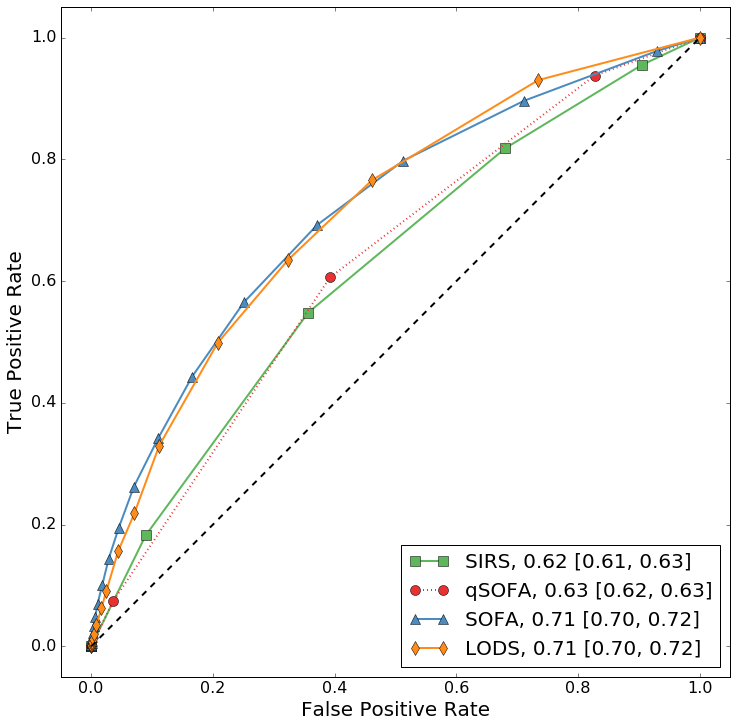

In [33]:
markers = {'qsofa': 'o:', 'sofa': '^-', 'sirs': 's-', 'mlods': 'd-'}
colors = {'qsofa': col[0], 'sofa': col[1], 'sirs': col[2], 'mlods': col[3]}
pred_pretty_text = {'qsofa': 'qSOFA', 'sofa': 'SOFA', 'sirs': 'SIRS', 'mlods': 'LODS'}
# plot the data
ax = plt.figure(figsize=[12,12]).add_subplot(111)

# ROC for each score in preds header
for pred in preds_header:
    fpr, tpr, thr = metrics.roc_curve(y, df[pred].values)
    auc, auc_ci = ru.calc_auc(df[pred].values, y, with_ci=True, alpha=0.05)
    
    plt.plot(fpr, tpr, markers[pred],
             color=colors[pred], linewidth=2, markersize=10,
             label=pred_pretty_text[pred] + ', ' +
             '{:0.2f} [{:0.2f}, {:0.2f}]'.format(auc, auc_ci[0], auc_ci[1]))

plt.legend(loc="lower right", fontsize=20)

plt.plot([0,1], [0,1], '--',
         color=[0,0,0], linewidth=2)

# reformat the plot
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16) 
#plt.title('ROC against in-hospital mortality',fontsize=14)
plt.show()